In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from IPython.core.display import display

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample



# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [4]:
train.shape

(8693, 14)

In [5]:
test.shape

(4277, 13)

In [6]:
train.describe().T.sort_values(by='std',ascending = False)

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00


In [7]:
train.describe(include=object)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


## EDA

<AxesSubplot:ylabel='Transported'>

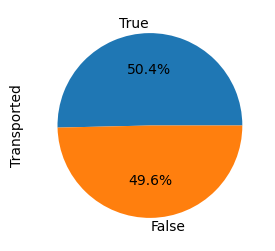

In [8]:
plt.figure(figsize=(3,3))
train['Transported'].value_counts().plot.pie(autopct='%1.1f%%')

<AxesSubplot:xlabel='Age', ylabel='Count'>

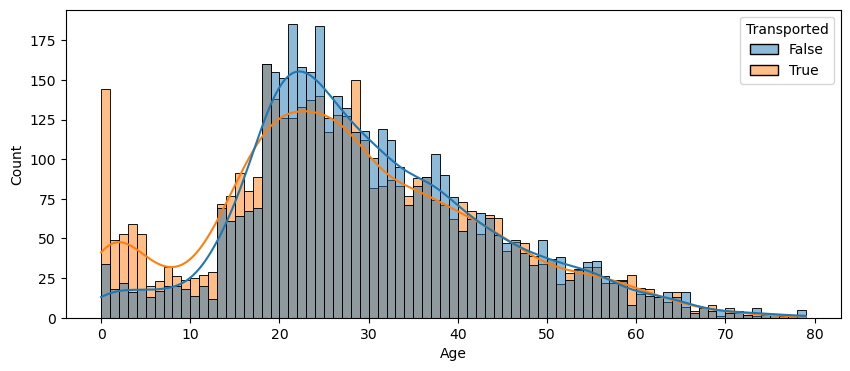

In [9]:
plt.figure(figsize=(10,4))
sns.histplot(data=train,x='Age',hue='Transported',binwidth=1,kde=True)

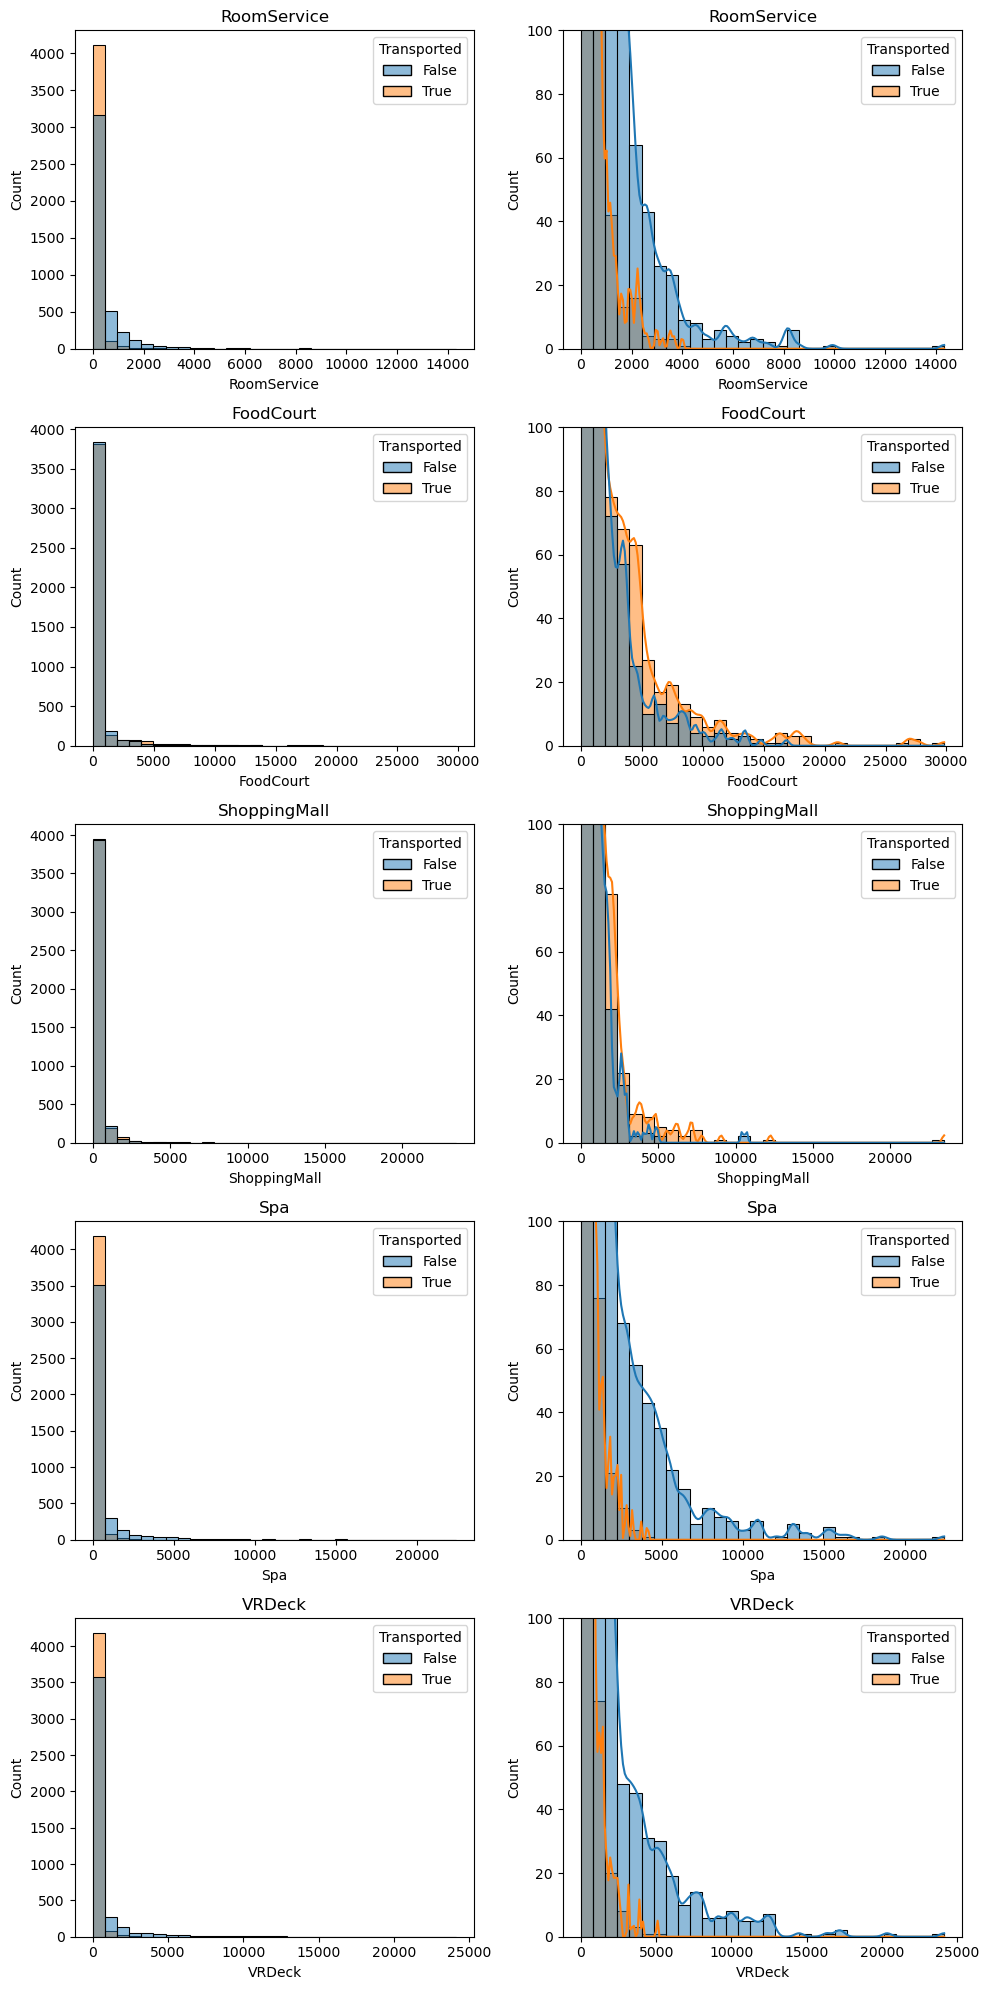

In [10]:
fig = plt.figure(figsize=(10,20))
#消費特徵
exp_feat = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for i, var_name in enumerate(exp_feat):
    #左
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # 右 (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

- 大部分的人都是沒有花費的，等等可以建立一個No_spending欄位作為特徵

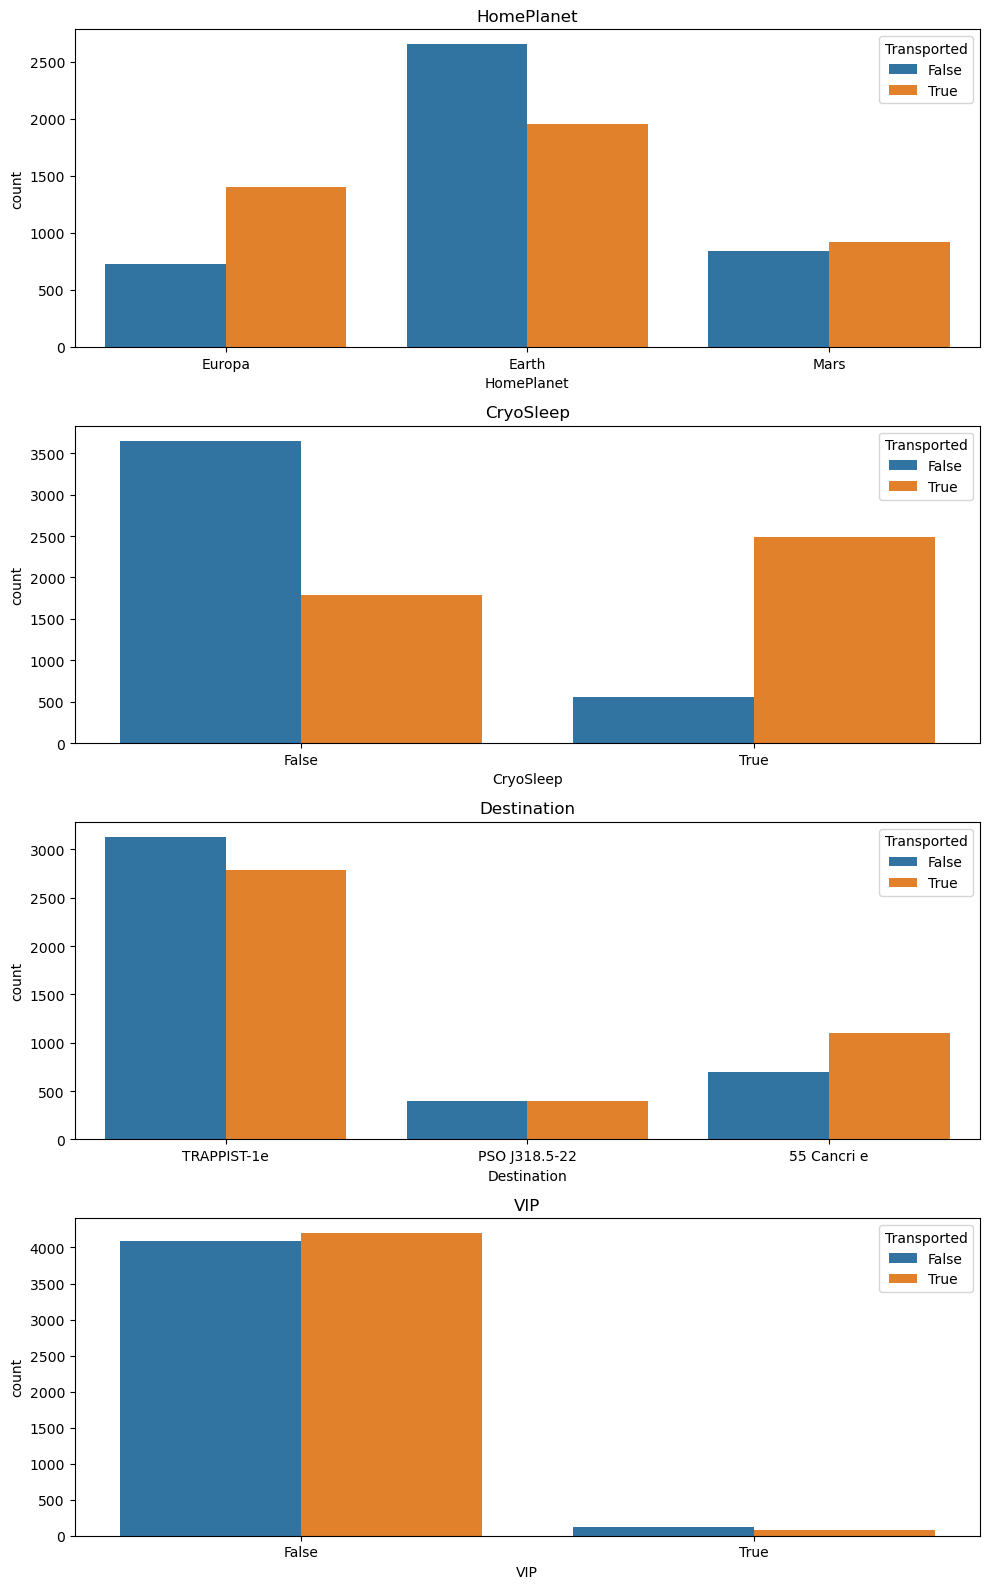

In [11]:
#類型欄位
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# 視覺化類型欄位
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  
plt.show()

- 大部分的人的原生星球是在earth，大概有各一半的火星人有傳輸
- 在冷凍艙的部分很明顯，有睡冷凍艙的大部分都會傳輸，而沒有睡的則大部分沒有傳輸
- 幾乎所有的人都去了TRAPPIST星球
- 幾乎所有人都沒有VIP，且有無Transported也是各半，對目標預測並沒有甚麼效益
### 洞見
- 再補值的時候可以參考HomPlanet,Destination來做補值，在聯合機率分布上而言

Text(0.5, 1.0, 'Age group distribution')

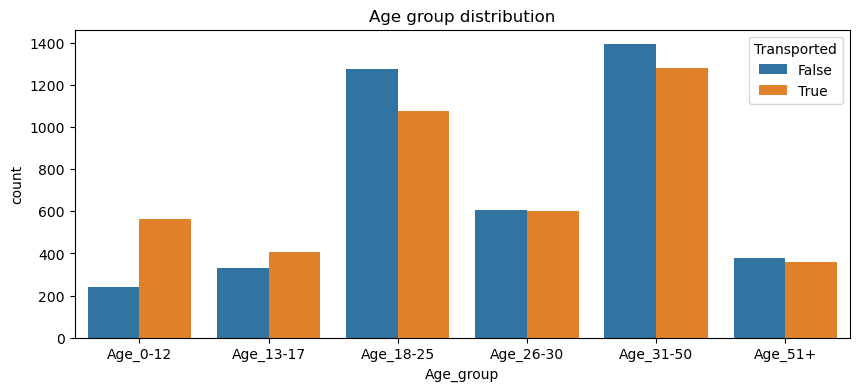

In [12]:
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group'] = 'Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group'] = 'Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group'] = 'Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')


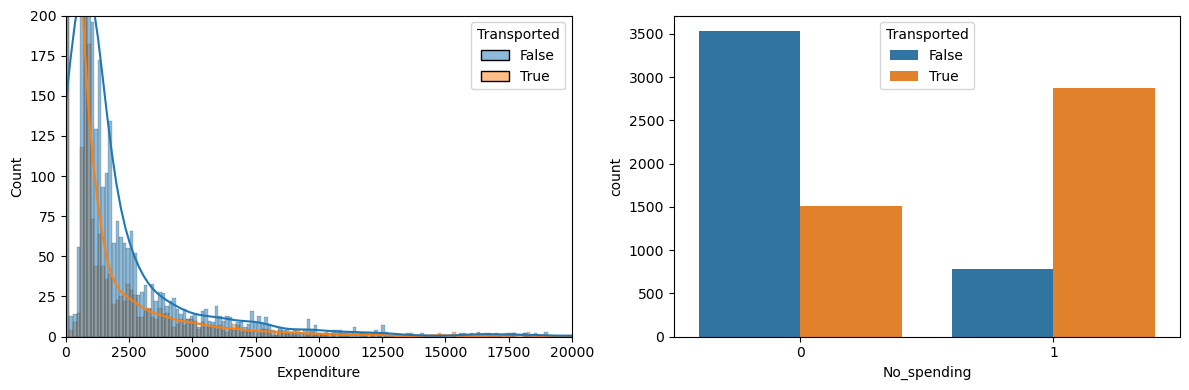

In [13]:
train['Expenditure'] = train[exp_feat].sum(axis=1)
train['No_spending'] = (train['Expenditure']==0).astype(int)

test['Expenditure'] = test[exp_feat].sum(axis=1)
test['No_spending'] = (test['Expenditure']==0).astype(int)

fig =plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train,x='Expenditure',hue='Transported',kde=True)
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train,x='No_spending',hue='Transported')
fig.tight_layout()

- 大部分人的花費很少，不少人甚至是沒有花費

In [14]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Age_group,Expenditure,No_spending
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning,Age_26-30,0.00,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers,Age_18-25,2832.00,0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus,Age_31-50,0.00,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter,Age_31-50,7418.00,0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez,Age_18-25,645.00,0


In [15]:
#將PassengerId進行拆解或取有用的特徵
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

train['Group_size'] = train['Group'].map(lambda x:pd.concat([train['Group'],test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

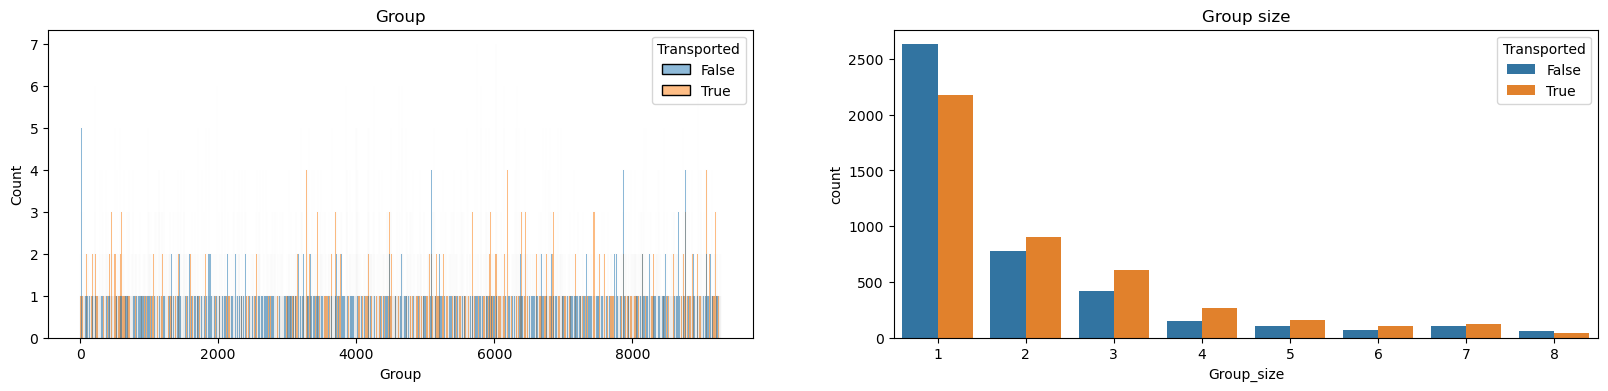

In [16]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

In [17]:
train['Group'].value_counts()

4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: Group, Length: 6217, dtype: int64

- 總共有6217組的團
- 團內人數是1~8人之間，大部分是1人
### 洞見
- 分割出單獨的Solo欄位來做有用的特徵

Text(0.5, 1.0, 'Passenger travelling solo or not')

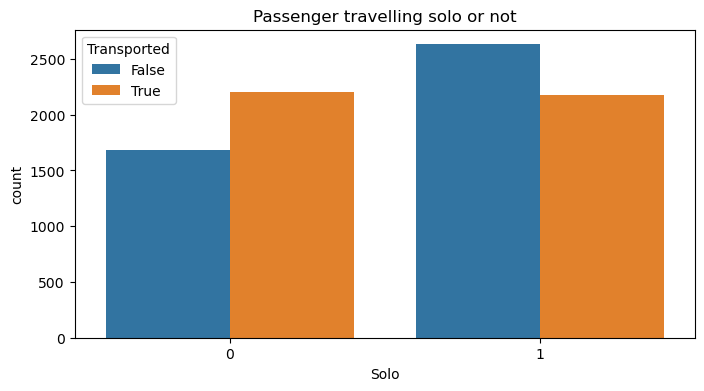

In [18]:
train['Solo'] = (train['Group_size']==1).astype(int)
test['Solo'] = (test['Group_size']==1).astype(int)
fig =plt.figure(figsize=(8,4))
sns.countplot(data=train,x='Solo',hue='Transported')
plt.title('Passenger travelling solo or not')

In [19]:
#處理Cabin欄未來獲取有用資訊
#將缺失值填入格式資料，以便後面拆分
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

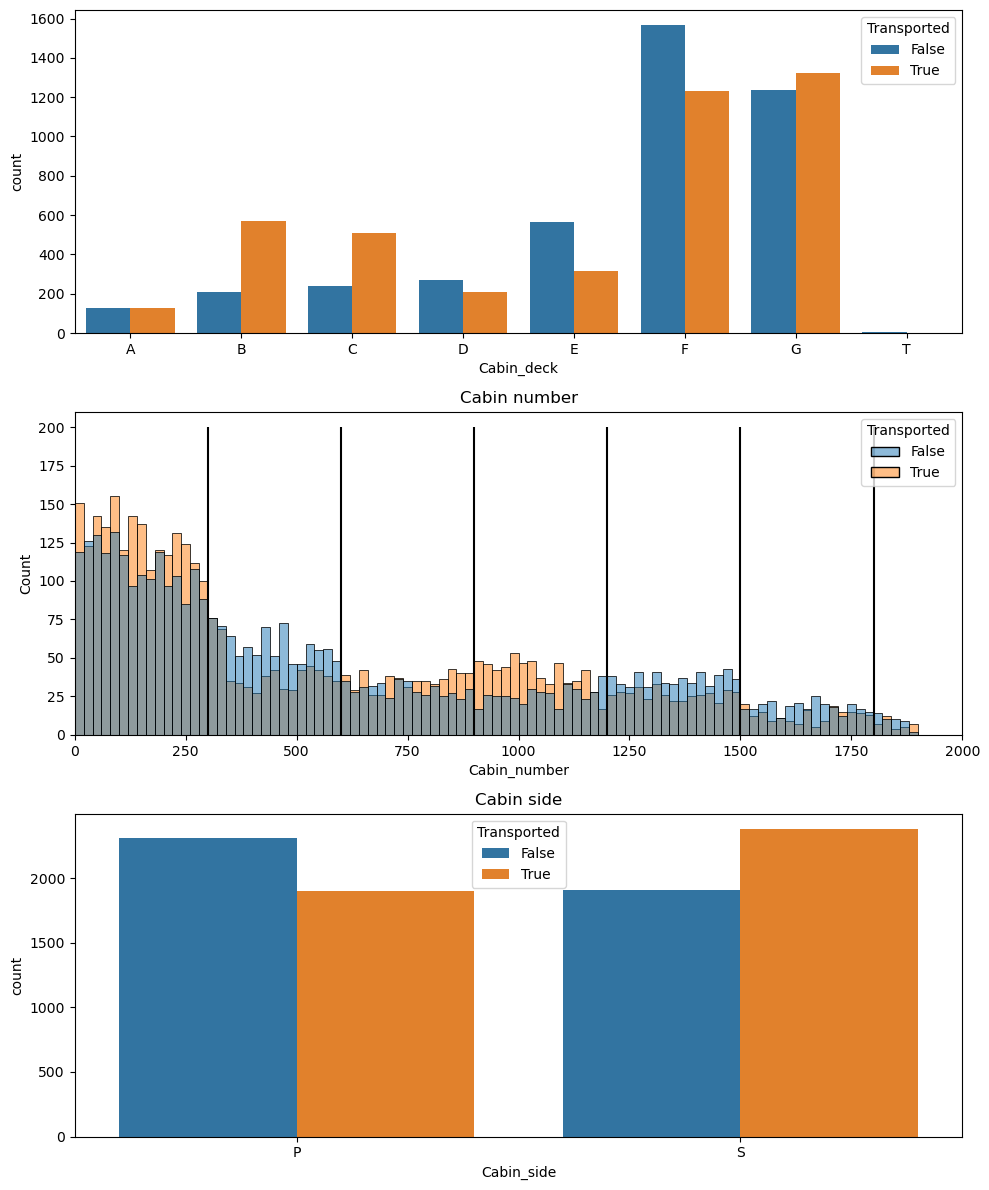

In [20]:
#split函數拆解
train['Cabin_deck'] = train['Cabin'].apply(lambda x:x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x:x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x:x.split('/')[2])
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])
#將本缺失的欄位用na取代回來
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# train.drop('Cabin', axis=1, inplace=True)
# test.drop('Cabin', axis=1, inplace=True)

fig =plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train,x='Cabin_deck',hue='Transported',order =['A','B','C','D','E','F','G','T'])
plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

- 總共有8個甲板，大部分的人是在F,G上
- Cabin_number可以將其分組成分類型資料

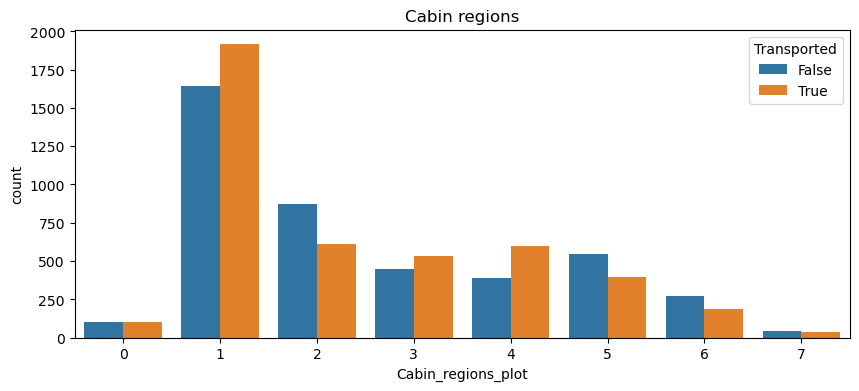

In [21]:
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

Text(0.5, 1.0, 'Family size')

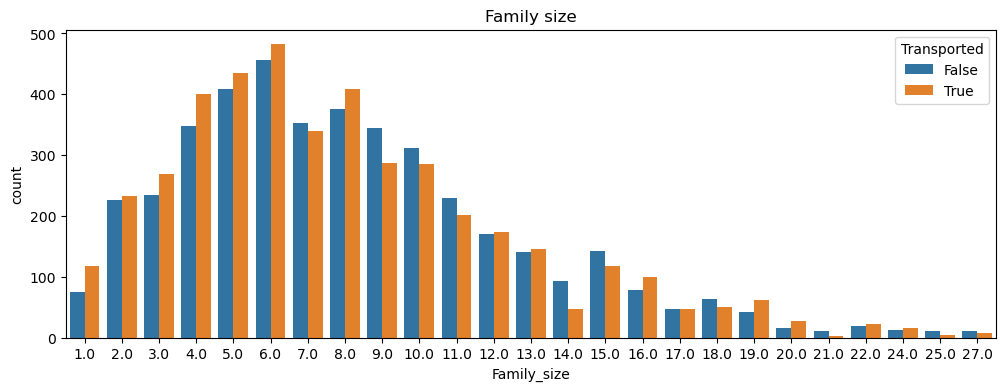

In [22]:
train['Name'].fillna('Unknown Unknown',inplace=True)
test['Name'].fillna('Unknown Unknown',inplace=True)

train['Surname'] = train['Name'].str.split().str[-1]
test['Surname'] = train['Name'].str.split().str[-1]

train['Family_size'] = train['Surname'].map(lambda x:pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size'] = test['Surname'].map(lambda x:pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

train.loc[train['Surname']=='Unknown','Surname'] = np.nan
train.loc[train['Family_size']>100,'Family_size'] = np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

train.drop(columns='Name',axis=1,inplace=True)
test.drop(columns='Name',axis=1,inplace=True) 

fig = plt.figure(figsize=(12,4))
sns.countplot(data= train,x='Family_size',hue='Transported')
plt.title('Family size')

## 缺失值處理

In [23]:
y = train['Transported'].copy().astype(int)
X = train.drop('Transported',axis=1).copy()
data=pd.concat([X, test], axis=0).reset_index(drop=True)

In [24]:
na_cols = data.columns[data.isna().any()].to_list()
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


- 資料的缺失值大概都在2%左右

Text(0.5, 1.0, 'Heatmap of missing values')

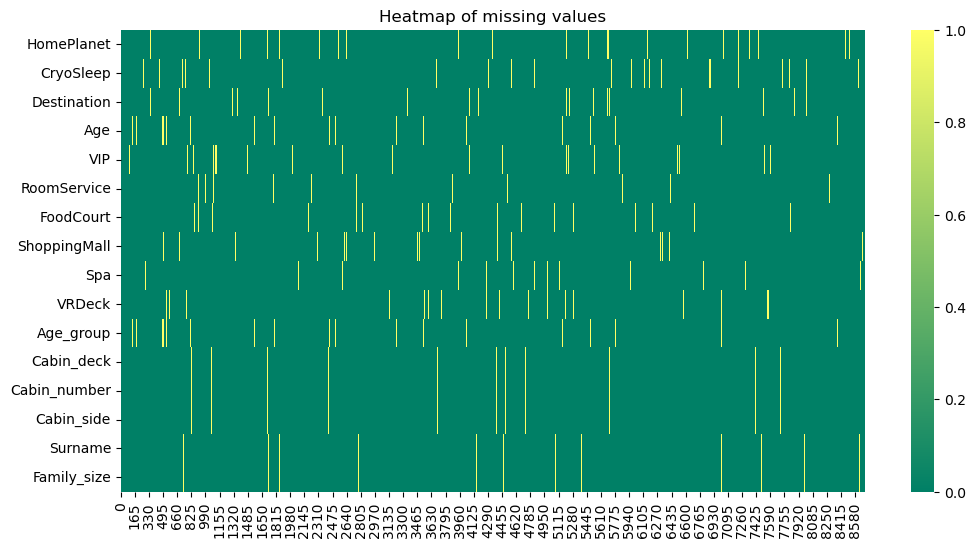

In [25]:
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

- 幾乎很少缺失值連續出現(同一個欄位連續)#如果有光譜會有橫線

<AxesSubplot:xlabel='na_count', ylabel='count'>

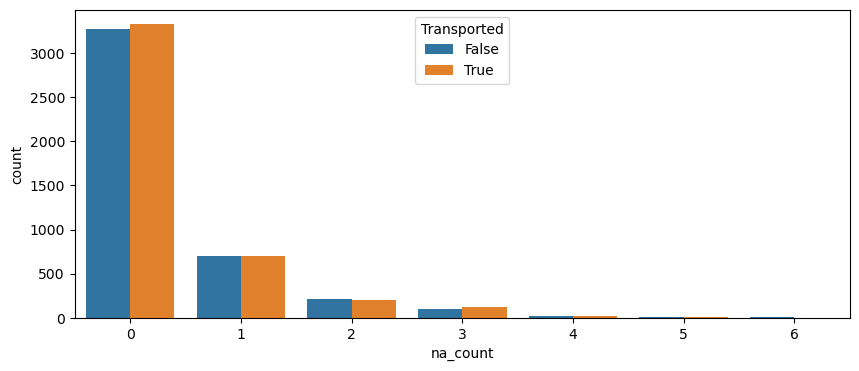

In [26]:
#看一個index中會出現多少個缺失，如果很多就可能drop，比較不會影響fit的準確度(overfitting)
train['na_count']=train.isna().sum(axis=1)
fig =plt.figure(figsize=(10,4))
sns.countplot(data=train,x='na_count',hue='Transported')

- 大部分欄位是沒有缺失，有25%的資料是有1個缺失的欄位，不過幾乎最多一欄只會有3個缺失值
- 如果在PassengerId和其他的特徵之間有關聯，我們可以以那些欄位去做補值，而不直接drop掉該行資料

In [27]:
#補HomePlanet的缺失值，HomePlanet是指原生星球，若同一個group來自同一個星球的可能性應該會相當大，就好比家庭旅遊
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.00,1.00,0.00
2,1.00,0.00,0.00
3,0.00,2.00,0.00
4,1.00,0.00,0.00
5,1.00,0.00,0.00


- 可以看出，同一個group，會來自同一個星球#舉例group=3的那行是2代表只有兩個人(family_size=2),都來自Europa
- 所以如果homeplanet欄位有缺失，但他跟另一個沒有缺失的人都是同一個group的話那他跟沒有缺失的人來自同星球的機率很高，就可以拿該人的值去補填

Text(0.5, 1.0, 'Number of unique home planets per group')

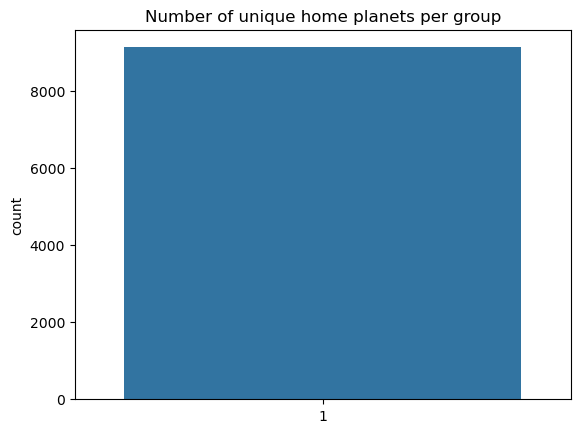

In [28]:
#視覺化
#如果有2代表來自兩個星球
sns.countplot((GHP_gb>0).sum(axis=1))
plt.title('Number of unique home planets per group')

In [29]:
#補值前
HP_bef=data['HomePlanet'].isna().sum()
#找出那些同一個group，但homeplanet缺失的人的索引
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index
#補值後
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


<AxesSubplot:xlabel='Cabin_deck', ylabel='HomePlanet'>

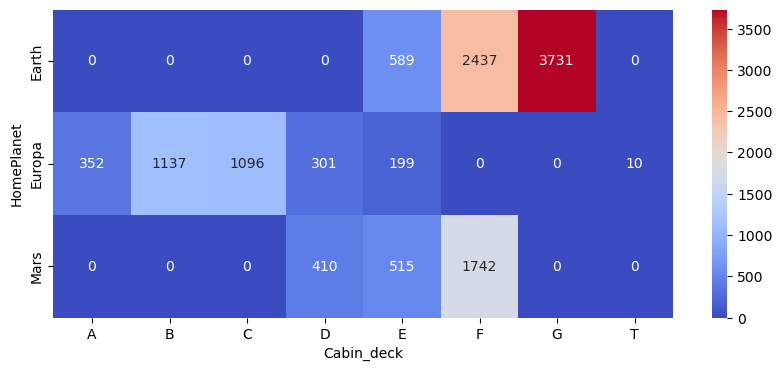

In [30]:
#看Cabin_deck上不同的甲板，人都來自哪個星球
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# 視覺化
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

- 可以發現F,T上有最多人，而G甲板上的人都是來自Earth。 C,b甲板上都是來自Europa，而E甲板上3個星球的人都有
- 所以我們可以以cabin_deck上的甲板位置來補值，舉例來說，如果有來自G甲板的人但是他的HomePlent的欄位是缺失的，就可以以Earth來做補值

In [31]:
# 補前
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C 或 T 用 Europa補
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G 用 Earth 補
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'
#結果
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


Text(0.5, 1.0, 'Number of unique planets per surname')

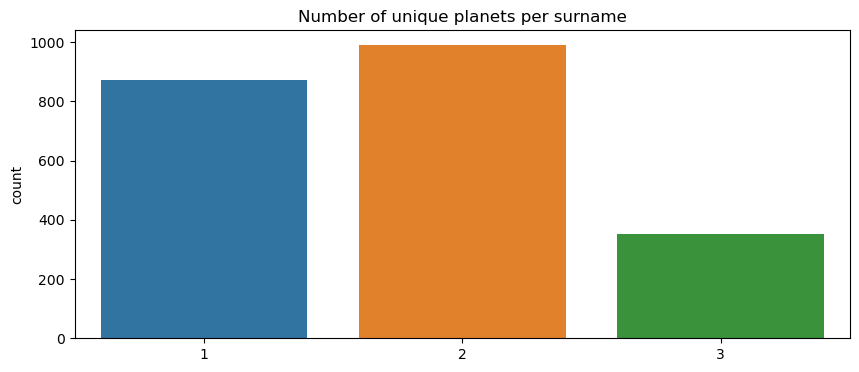

In [32]:
#  Surname and HomePlanet的聯合機率分布
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

#視覺化
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')

- 總共有2215個姓氏。姓氏來自同一星球的有快900個，來自2個星球的快1000個，3個星球的最少

In [33]:
HP_bef=data['HomePlanet'].isna().sum()

#有著HomePlanet缺失值的人，也有同一個Surname，以沒缺失的去補值
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

#將這些HomePlanet是缺失的人但有surname，已該姓氏在星球中出現最大的次數來補植 
#Ex:Acobson在Earth次數是最大的，Adavisons在Earth有11.00人在Europa有5.00人用Earth來補缺失值
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 7


In [34]:
SHP_gb.idxmax(axis=1)

Surname
Acobson         Earth
Acobsond        Earth
Adavisons       Earth
Adkinson        Earth
Admingried     Europa
                ...  
Wynneyerson     Earth
Yanton          Earth
Yatters         Earth
Yorkland        Earth
Youngrayes      Earth
Length: 2215, dtype: object

In [35]:
SHP_gb

HomePlanet,Earth,Europa,Mars
Surname,,,
Acobson,4.00,0.00,0.00
Acobsond,4.00,0.00,1.00
Adavisons,11.00,5.00,0.00
Adkinson,5.00,0.00,0.00
Admingried,0.00,4.00,0.00
...,...,...,...
Wynneyerson,3.00,0.00,0.00
Yanton,10.00,0.00,0.00
Yatters,4.00,1.00,0.00


In [36]:
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5252,5603_01,NaN,TRAPPIST-1e
5634,5989_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
12156,7555_01,NaN,55 Cancri e


- 剩下的缺失值大部分目的地都是去TRAPPIST-1e

<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

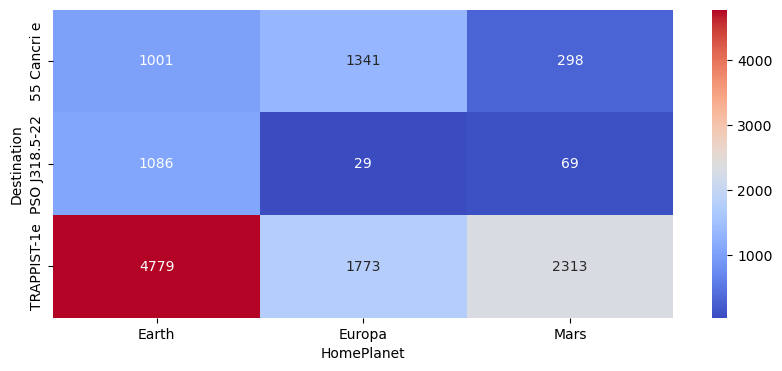

In [37]:
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)
#視覺化
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

- 去TRAPPIST-1e最多的是來自Earth

In [38]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()
#剩下的缺失值都是去TRAPPIST-1e，而他們大多來自Earth，也有來自其他星球,但從earth來的人都不會出現在Cabin_deck是D甲板
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 7
#HomePlanet missing values after: 0


In [39]:
#補值前
D_bef=data['Destination'].isna().sum()
#用眾數補值TRAPPIST-1e
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


Text(0.5, 1.0, 'Number of unique surnames by group')

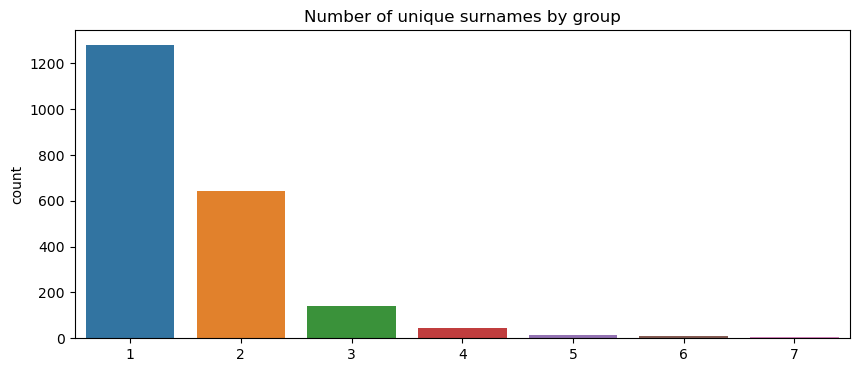

In [40]:
#  Group 和 Surname的聯合機率分布
# 因為要補植，所以要group_size>1才行，將Group_size>1的人選出來，用group surname來分組
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)
#視覺化
plt.figure(figsize=(10,4))
sns.countplot((GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')

- 組別裡只有一個姓氏的有1200多組，有2個姓氏的有600多

In [41]:
#該部分補值同上概念
SN_bef=data['Surname'].isna().sum()

GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 301
#Surname missing values after: 163


In [42]:
# 取代Nan 才可以使用map
data['Surname'].fillna('Unknown', inplace=True)

In [43]:
# 更新family size 特徵
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# 把Nan取代回去
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# 把Family_size裡的unknown改成0
data.loc[data['Family_size']>100,'Family_size']=0

In [44]:
data['Surname'].value_counts()

Casonston     27
Litthews      26
Garnes        24
Barbes        24
Browlerson    22
              ..
Persoffly      1
Bette          1
Venticable     1
Stanters       1
Sionerorly     1
Name: Surname, Length: 2217, dtype: int64

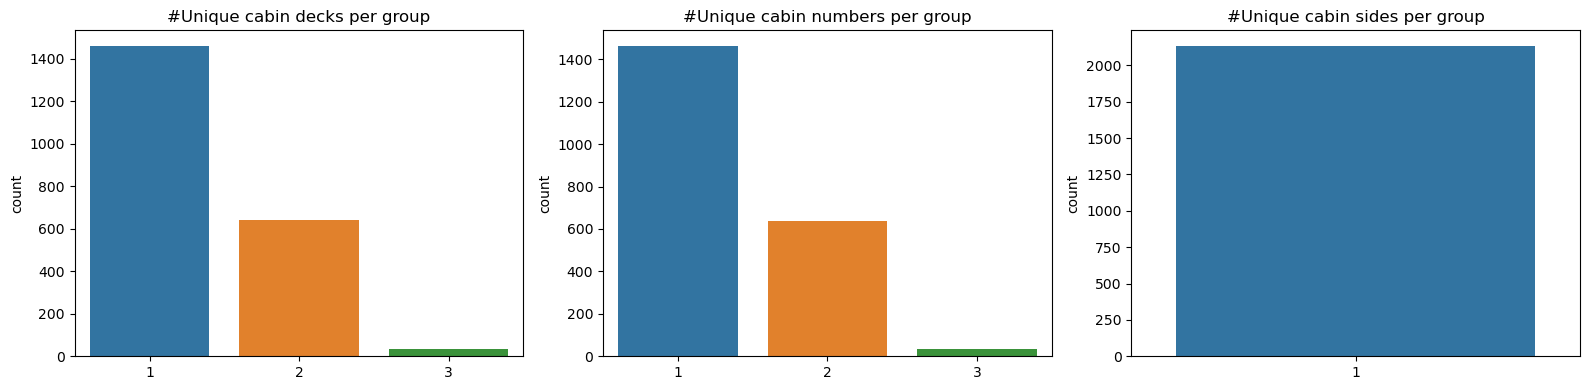

In [45]:
#Group and Cabin 的聯合機率分布
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((GCD_gb>0).sum(axis=1))
plt.title('#Unique cabin decks per group')

plt.subplot(1,3,2)
sns.countplot((GCN_gb>0).sum(axis=1))
plt.title('#Unique cabin numbers per group')

plt.subplot(1,3,3)
sns.countplot((GCS_gb>0).sum(axis=1))
plt.title('#Unique cabin sides per group')
fig.tight_layout()

In [46]:
GCD_gb

Cabin_deck,A,B,C,D,E,F,G,T
Group,,,,,,,,
3,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
8,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00
17,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
20,0.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...
9266,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
9267,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00
9272,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00


- 組只出現在一個cabin decks裡的有1400多組，組現在兩個甲板的600組
- 組只出現在一個cabin numbers的有1400多組，組現在兩個甲板的600組
- 所有cabin sides裡的人都是同一個group

In [47]:
CS_bef=data['Cabin_side'].isna().sum()

GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


Text(0.5, 1.0, 'Ratio of cabin side by surname')

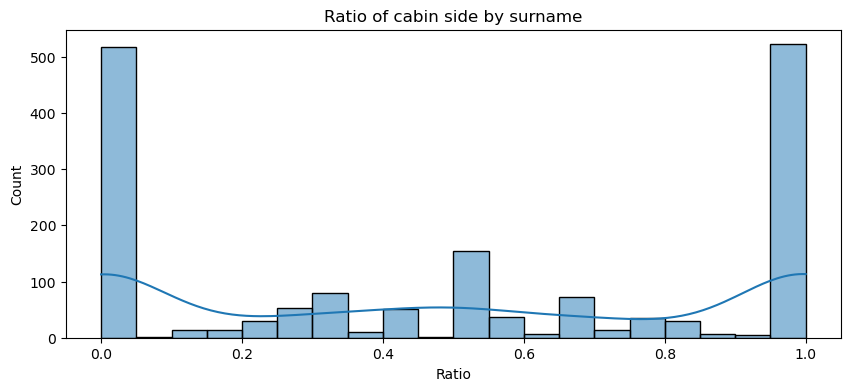

In [48]:
# Surname and Cabin side 的聯合機率分布
SCS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')

In [49]:
# 比率
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 62.9 %


Cabin_side,P,S,Ratio
Surname,,,
Acobson,0.00,3.00,0.00
Acobsond,1.00,0.00,1.00
Adavisons,9.00,4.00,0.69
Adkinson,1.00,0.00,1.00
Admingried,0.00,4.00,0.00


In [50]:
#補值前
CS_bef=data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

#沒有Cabin_side但是有Surname的乘客的索引
SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# 補值
data.loc[SCS_index,'Cabin_side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop surname (不需要了)
data.drop('Surname', axis=1, inplace=True)

print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 162
#Cabin_side missing values after: 33


In [51]:
# Value counts
data['Cabin_side'].value_counts()

S    6510
P    6427
Name: Cabin_side, dtype: int64

In [52]:
#補值前
CS_bef=data['Cabin_side'].isna().sum()

#使用異常值補剩餘缺失值
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 33
#Cabin_side missing values after: 0


In [53]:
#同一組group容易出現在同一個甲板上
# 補值前
CD_bef=data['Cabin_deck'].isna().sum()
#沒有Cabin_deck但在同一組有主要Cabin_deck的乘客
GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index
#填值
data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


In [54]:
data.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0      0.00   0.00   0.00   0.00  20.00   90.00   
                         1      0.00   0.00   0.00   1.00  48.00  289.00   
           PSO J318.5-22 0      0.00   0.00   0.00   0.00  18.00   67.00   
                         1      0.00   0.00   0.00   0.00  25.00  263.00   
           TRAPPIST-1e   0      0.00   0.00   0.00   0.00 133.00  438.00   
                         1      0.00   0.00   0.00   2.00 361.00 1345.00   
Europa     55 Cancri e   0     96.00 377.00 313.00  59.00  35.00    0.00   
                         1     67.00 141.00 159.00  45.00  34.00    1.00   
           PSO J318.5-22 0      2.00   5.00  11.00   0.00   0.00    0.00   
                         1      0.00   0.00  10.00   0.00   0.00    0.00   
           TRAPPIST-1e   0    152.00 459.00 428.00 120.00  53.00    0.00   
                         1     44.00 179.00 201.00  85.00  82.00    3.00   
Mars       55 Cancri e   0      0.00   0.00   0.00  32.00  15.00  104.00   
                         1      0.00   0.00   0.00  40.00  15.00   91.00   
           PSO J318.5-22 0      0.00   0.00   0.00   8.00   9.00   14.00   
                         1      0.00   0.00   0.00   9.00   7.00   20.00   
           TRAPPIST-1e   0      0.00   0.00   0.00 168.00 219.00  798.00   
                         1      0.00   0.00   0.00 161.00 260.00  745.00   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0     272.00 0.00  
                         1     269.00 0.00  
           PSO J318.5-22 0     230.00 0.00  
                         1     466.00 0.00  
           TRAPPIST-1e   0    1075.00 0.00  
                         1    1509.00 0.00  
Europa     55 Cancri e   0       0.00 2.00  
                         1       0.00 0.00  
           PSO J318.5-22 0       0.00 0.00  
                         1       0.00 0.00  
           TRAPPIST-1e   0       0.00 1.00  
                         1       0.00 8.00  
Mars       55 Cancri e   0       0.00 0.00  
                         1       0.00 0.00  
           PSO J318.5-22 0       0.00 0.00  
                         1       0.00 0.00  
           TRAPPIST-1e   0       0.00 0.00  
                         1       0.00 0.00

In [55]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()
#用眾數填值
na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 162
#Cabin_deck missing values after: 0


Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

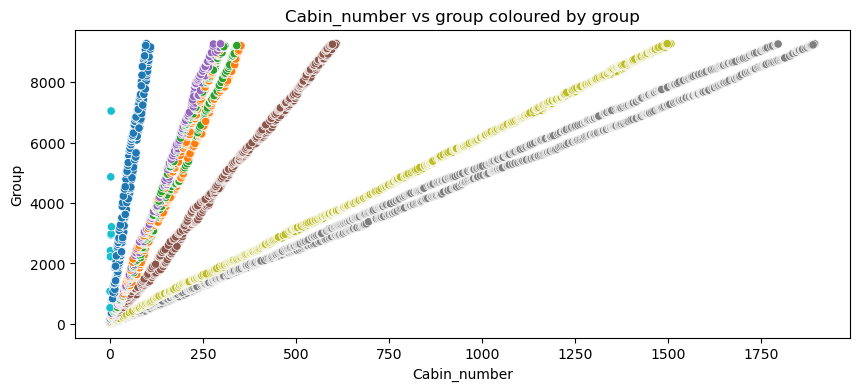

In [56]:
# 散點圖
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']),cmap='tab10')
plt.title('Cabin_number vs group coloured by group')

- 這裡有一個有趣的模式。cabin_number和group_number有線性關係。因此，我們可以使用逐層的線性回歸來推斷缺失的客艙編號，以獲得近似的客艙編號。

In [57]:
# 補值前
CN_bef=data['Cabin_number'].isna().sum()

#逐層推斷線性關係
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # 特徵和目標
    X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

    # 線性回歸
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))

    #用預測值填值
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


In [58]:
# One-hot encode cabin regions
data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int)

In [59]:
# 補值前
V_bef=data['VIP'].isna().sum()

#用眾數補值
data.loc[data['VIP'].isna(),'VIP']=False

print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


In [60]:
# 聯合機率分布
data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0     0.00  0.00  0.00  0.00 24.00 25.00 28.00  0.00
                       1     0.00  0.00  0.00 45.00 25.00 24.00 26.00  0.00
           1           0     0.00  0.00  0.00  0.00  7.00 16.00  8.00  0.00
                       1     0.00  0.00  0.00 45.00 24.50 23.00 23.00  0.00
Europa     0           0    35.00 34.00 33.00 33.00 34.00  0.00  0.00 44.00
                       1    35.00 36.00 35.50 34.00 35.00 30.00  0.00 35.00
           1           0    30.00 27.00 28.50 27.00 28.00  0.00  0.00  0.00
                       1    37.50 34.00 35.00 31.00 33.00 35.00  0.00  0.00
Mars       0           0     0.00  0.00  0.00 30.00 29.00 29.00  0.00  0.00
                       1     0.00  0.00  0.00 31.00 28.00 30.00  0.00  0.00
           1           0     0.00  0.00  0.00 29.50 26.00 18.00  0.00  0.00
                       1     0.00  0.00  0.00 31.00 30.00 29.00  0.00  0.00

- 年齡因許多特徵而異，例如HomePlanet，團體規模，支出和客艙甲板，因此我們將根據這些子組的中位數估算缺失值

In [61]:
#補值前
A_bef=data[exp_feat].isna().sum().sum()

# 分組後的中位數填值
na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].transform(lambda x:x.fillna(x.median()))[na_rows_A]

print('#Age missing values before:',A_bef)
print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 1410
#Age missing values after: 0


In [62]:
# 更新 age group feature
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

In [63]:
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.00,0.00
1,740.00,4581.00


- 最好去預測冷凍艙的就是看他有沒有花費

In [64]:
CSL_bef=data['CryoSleep'].isna().sum()

#用眾數填值
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


In [65]:
print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True,exp_feat].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [66]:
#補值前 
E_bef=data[exp_feat].isna().sum().sum()

# 有使用CryoSleep，就是沒消費
for col in exp_feat:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feat].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


In [67]:
#分組後平均值
data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12  Age_13-17  Age_18-25  Age_26-30  Age_31-50  Age_51+
HomePlanet Solo                                                               
Earth      0         0.00     724.90     789.70     841.09     736.66   733.65
           1         0.00     693.01     779.14     797.38     802.45   827.80
Europa     0         0.00    1153.16    2652.01    3534.67    3975.77  3483.64
           1         0.00       0.00    2481.39    3806.23    3927.85  3952.09
Mars       0         0.00    1176.84    1161.81    1247.10    1143.67  1345.42
           1         0.00    1687.26    1072.71    1082.45    1114.00  1098.69

In [68]:
# 補值前
E_bef=data[exp_feat].isna().sum().sum()

# 用分組後平均值補值
for col in exp_feat:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
    
# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feat].isna().sum().sum())

#Expenditure missing values before: 866
#Expenditure missing values after: 0


In [69]:
# 更新expenditure and no_spending
data['Expenditure']=data[exp_feat].sum(axis=1)
data['No_spending']=(data['Expenditure']==0).astype(int)

In [70]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Cabin            0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Age_group        0
Expenditure      0
No_spending      0
Group            0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_number     0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64

In [71]:
# Train and test
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [72]:
# 刪除定性/冗餘/共線/高基數特徵
X.drop(['Cabin','PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['Cabin','PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

#### Log 轉換

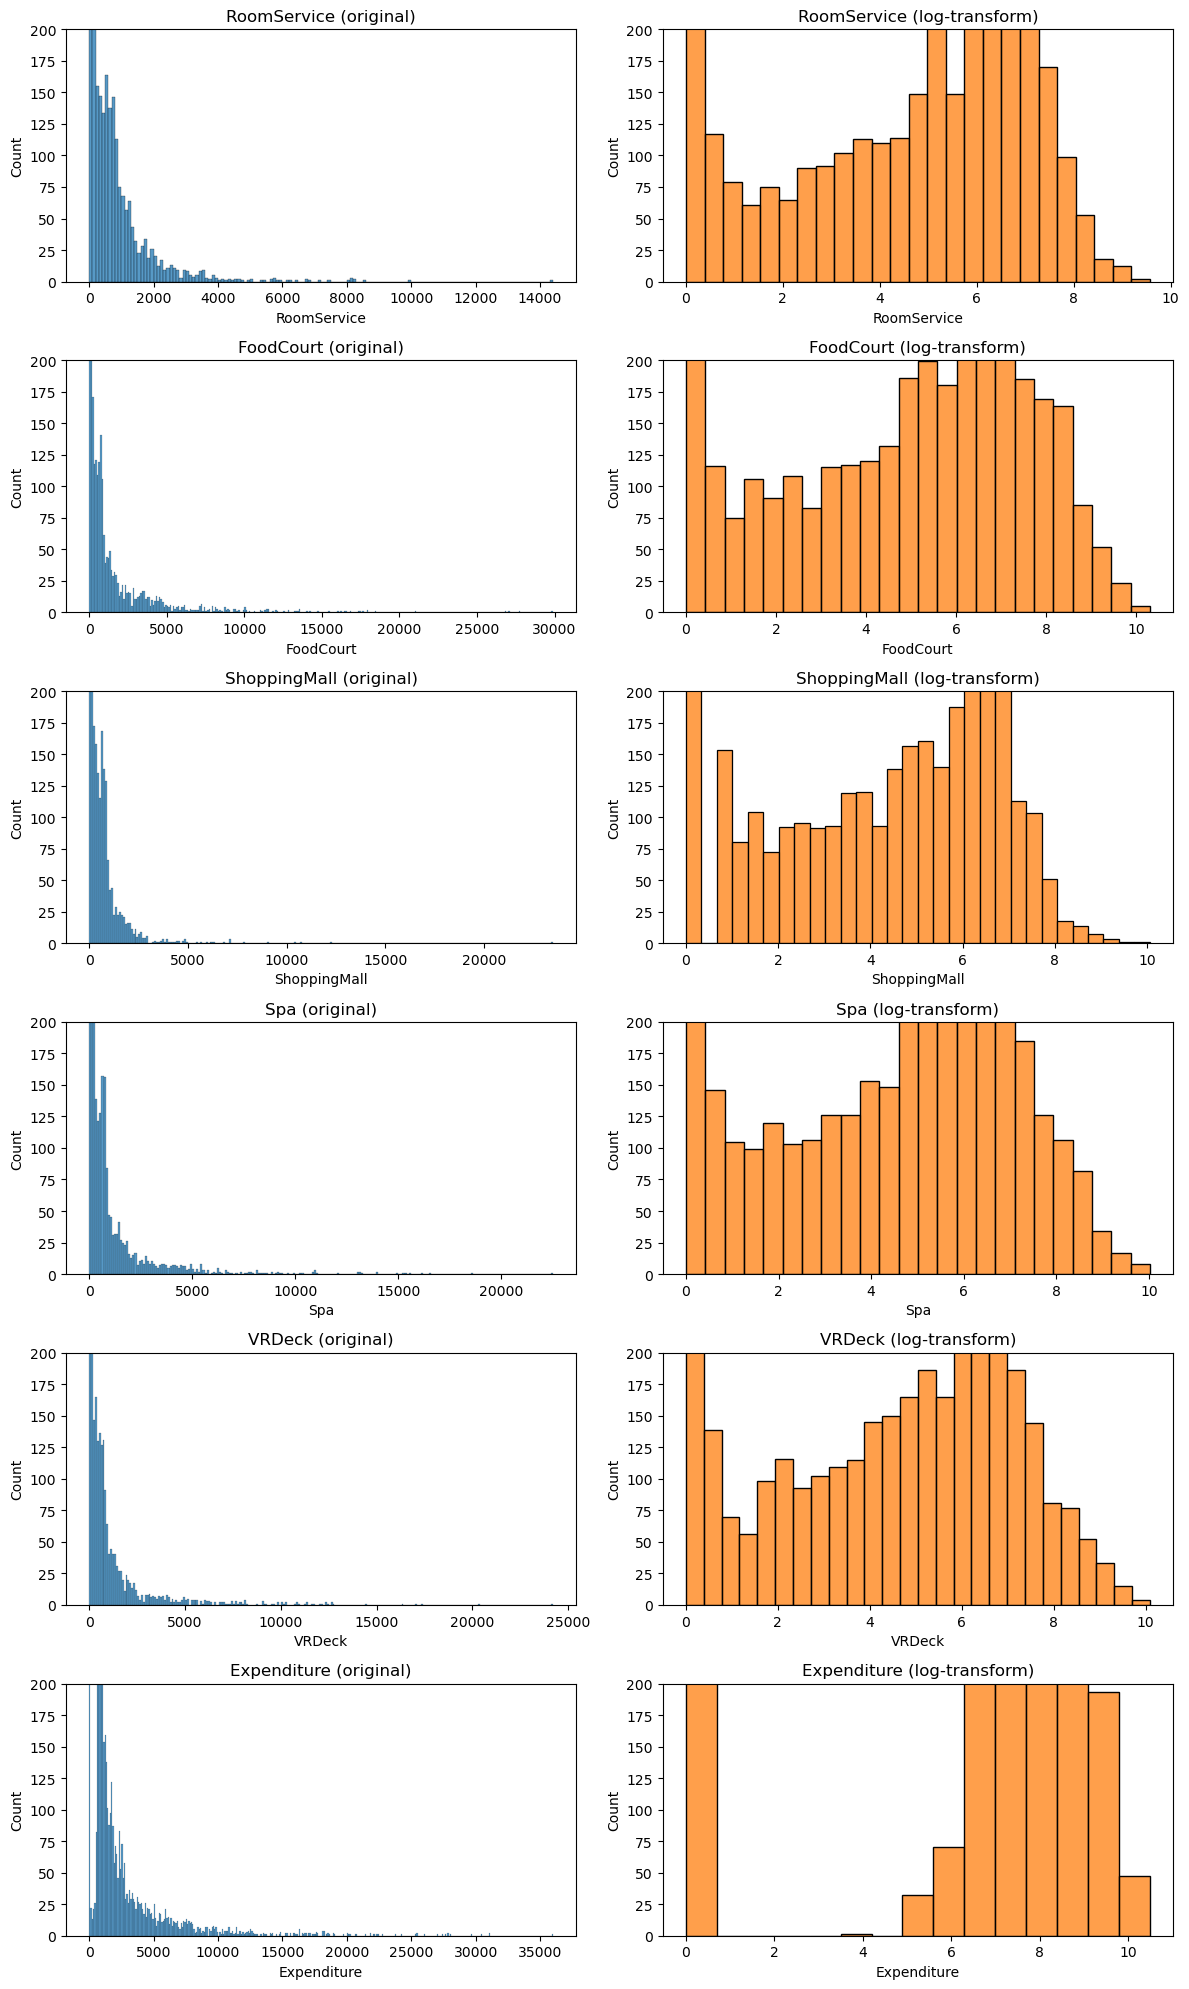

In [73]:
#對數變換用於減少分佈中的偏斜，尤其是對於較大的異常值。它可以使演算法更容易“學習”正確的關係。將其應用於支出特徵，因為這些特徵受到異常值的嚴重偏斜。
#視覺化
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [74]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

In [75]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,Europa,False,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,...,B,P,1,0,0,0,0,0,0,2
1,Earth,False,TRAPPIST-1e,24.00,False,4.70,2.30,3.26,6.31,3.81,...,F,S,1,0,0,0,0,0,0,6
2,Europa,False,TRAPPIST-1e,58.00,True,3.78,8.18,0.00,8.81,3.91,...,A,S,1,0,0,0,0,0,0,10
3,Europa,False,TRAPPIST-1e,33.00,False,0.00,7.16,5.92,8.11,5.27,...,A,S,1,0,0,0,0,0,0,10
4,Earth,False,TRAPPIST-1e,16.00,False,5.72,4.26,5.02,6.34,1.10,...,F,S,1,0,0,0,0,0,0,11


In [76]:
X.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure',
       'No_spending', 'Solo', 'Cabin_deck', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Family_size'],
      dtype='object')

In [77]:
label_col = ['HomePlanet','CryoSleep','Destination','VIP','Cabin_deck','Cabin_side']
def label_encode(X,X_test,columns):
    for col in columns:
        X[col]=X[col].astype(str)
        X_test[col]=X_test[col].astype(str)
        X[col]=LabelEncoder().fit_transform(X[col])
        X_test[col]=LabelEncoder().fit_transform(X_test[col])
    return X,X_test
X,X_test = label_encode(X,X_test,label_col)

In [78]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,1,0,2,39.00,0,0.00,0.00,0.00,0.00,0.00,...,1,0,1,0,0,0,0,0,0,2
1,0,0,2,24.00,0,4.70,2.30,3.26,6.31,3.81,...,5,1,1,0,0,0,0,0,0,6
2,1,0,2,58.00,1,3.78,8.18,0.00,8.81,3.91,...,0,1,1,0,0,0,0,0,0,10
3,1,0,2,33.00,0,0.00,7.16,5.92,8.11,5.27,...,0,1,1,0,0,0,0,0,0,10
4,0,0,2,16.00,0,5.72,4.26,5.02,6.34,1.10,...,5,1,1,0,0,0,0,0,0,11


In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [80]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_valid , y_train , y_valid)

100%|██████████| 29/29 [00:15<00:00,  1.87it/s]


In [81]:
models.head()

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.80,0.80,0.80,0.80,0.11
XGBClassifier,0.80,0.80,0.80,0.80,0.27
SVC,0.79,0.79,0.79,0.79,2.11
NuSVC,0.78,0.78,0.78,0.78,2.48
AdaBoostClassifier,0.78,0.78,0.78,0.78,0.26


In [83]:
RANDOM_STATE = 12 
FOLD = 5
STRATEGY = 'median'
TARGET='Transported'
lgb_params = {
    'objective' : 'binary',
    'n_estimators' :50,
    'learning_rate' : 0.08
}
lgb_predictions =0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(X.columns)
skf =StratifiedKFold(n_splits=FOLD,shuffle=True,random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(X[LGBM_FEATURES], y)):
    print(f'\033[94m')
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = X.iloc[train_idx][LGBM_FEATURES], X.iloc[valid_idx][LGBM_FEATURES]
    y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%")
    test_preds = model.predict(X_test[LGBM_FEATURES]) 
    lgb_predictions += test_preds/FOLD
print("")
print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
Fold=1, Accuracy score: 0.81%

========== Fold=2 ==========
Fold=2, Accuracy score: 0.80%

========== Fold=3 ==========
Fold=3, Accuracy score: 0.80%

========== Fold=4 ==========
Fold=4, Accuracy score: 0.81%

========== Fold=5 ==========
Fold=5, Accuracy score: 0.82%

Mean Accuracy : 0.8077773094201858


## Submission

In [84]:
submission[TARGET] = lgb_predictions.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
